In [68]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
import numpy as np
import matplotlib.pyplot as plt

# Cargar los datos
movies_df = pd.read_csv("data/movie_statistic_dataset.csv")

# Selección de columnas relevantes
relevant_columns = [
    "production_date",
    "genres",
    "runtime_minutes",
    # "director_name",
    "movie_averageRating",
    "movie_numerOfVotes",
    "approval_Index",
    "Production budget $",
    "Domestic gross $",
    "Worldwide gross $",
]
movies_df = movies_df[relevant_columns]

movies_df = movies_df.dropna()

movies_df["production_date"] = pd.to_datetime(movies_df["production_date"])


movies_df["production_year"] = movies_df["production_date"].dt.year
movies_df["production_month"] = movies_df["production_date"].dt.month
movies_df["production_day"] = movies_df["production_date"].dt.day

movies_df = movies_df.drop(columns=["production_date"])

# Split the 'genres' column into three separate columns
def split_genres(genres):
    genres_list = genres.split(",") if isinstance(genres, str) else []
    return pd.Series(genres_list[:3] + [None] * (3 - len(genres_list)))


movies_df[["genre_1", "genre_2", "genre_3"]] = movies_df["genres"].apply(split_genres)

# # Drop the original 'genres' column
movies_df = movies_df.drop(columns=["genres"])

# Separación de características y variable objetivo
X = movies_df.drop(columns=["Worldwide gross $"])
y = movies_df["Worldwide gross $"]

# Preprocesamiento de datos categóricos y numéricos
categorical_features = ["genre_1", "genre_2", "genre_3"]
numeric_features = [
    "runtime_minutes",
    "movie_averageRating",
    "movie_numerOfVotes",
    "approval_Index",
    "Production budget $",
    "Domestic gross $",
    "production_year",
    "production_month",
    "production_day",
]

# One-Hot Encoding for categorical features and Standard Scaling for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        # ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


pipeline = Pipeline(steps=[("preprocessor", preprocessor)])


X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

model = Sequential(
    [
        Dense(
            32,
            activation="relu",
            input_shape=(X_train_processed.shape[1],),
        ),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(1),  # Capa de salida para regresión
    ]
)

model.compile(
    optimizer=Adam(learning_rate=0.004), loss="mean_absolute_error", metrics=["mae"]
)

history = model.fit(
    X_train_processed, y_train, epochs=100, batch_size=32, validation_split=0.2
)
loss, mae = model.evaluate(X_test_processed, y_test)
print(f"Mean Absolute Error on Test Set: {mae}")

Epoch 1/100


/Users/adrian/.pyenv/versions/3.10.14/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 118471888.0000 - mae: 118471888.0000 - val_loss: 105378184.0000 - val_mae: 105378184.0000
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 123871552.0000 - mae: 123871552.0000 - val_loss: 95279464.0000 - val_mae: 95279464.0000
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 94734192.0000 - mae: 94734192.0000 - val_loss: 63491732.0000 - val_mae: 63491732.0000
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 65681500.0000 - mae: 65681500.0000 - val_loss: 44230900.0000 - val_mae: 44230900.0000
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 46798348.0000 - mae: 46798348.0000 - val_loss: 36462524.0000 - val_mae: 36462524.0000
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 39928176.0000 - mae: 39928176.0000 - val_loss: 32398414.0000 - val_mae: 32398414.0000
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 36074120.0000 - mae: 36074120.0000 - val_loss: 29612070.0000 - va

In [51]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

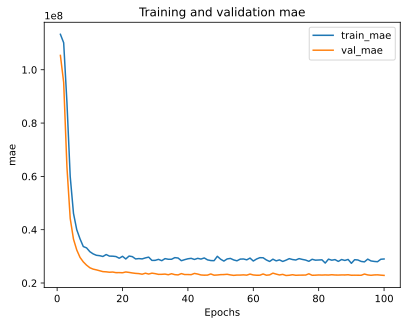

In [70]:
plot_metric(history, "mae")